# Introduction

This project aims to train a classification model that can predict if a user will accept a coupon given his/her answers to some survey questions. In this notebook, we will explore the feature engineering methods for categorical data using sklearn's pipeline and workflow.

The attributes of the data set include:

This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. For more information about the dataset, please refer to the paper: 
Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille. 'A bayesian framework for learning rule sets for interpretable classification.' The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393.

**User attributes**
* gender: male, female
* age: 21, 46, 26, 31, 41, 50plus, 36, below21 (e.g. 21 means 21 to 26, 26 means 26 to 31)
* maritalStatus: Unmarried partner, Single, Married partner, Divorced, Widowed 
* has_Children:1, 0 
* education: Some college - no degree, Bachelors degree, Associates degree, High School Graduate, Graduate degree (Masters or Doctorate), Some High School
* occupation: Unemployed, Architecture & Engineering, Student, Education&Training&Library, Healthcare Support, Healthcare Practitioners & Technical, Sales & Related, Management, Arts Design Entertainment Sports & Media, Computer & Mathematical, Life Physical Social Science, Personal Care & Service, Community & Social Services, Office & Administrative Support, Construction & Extraction, Legal, Retired, Installation Maintenance & Repair, Transportation & Material Moving, Business & Financial, Protective Service, Food Preparation & Serving Related, Production Occupations, Building & Grounds Cleaning & Maintenance, Farming Fishing & Forestry 
* income: \\$37500 - \\$49999, \\$62500 - \\$74999, \\$12500 - \\$24999, \\$75000 - \\$87499, \\$50000 - \\$62499, \\$25000 - \\$37499, \\$100000 or More, \\$87500 - \\$99999, Less than \\$12500 
* Bar: never, less1, 1\~3, gt8, nan4\~8 (feature meaning: how many times do you go to a bar every month?) 
* CoffeeHouse: never, less1, 4\~8, 1\~3, gt8, nan (feature meaning: how many times do you go to a coffeehouse every month?)
* CarryAway:n4\~8, 1\~3, gt8, less1, never (feature meaning: how many times do you get take-away food every month?) 
* RestaurantLessThan20: 4\~8, 1\~3, less1, gt8, never (feature meaning: how many times do you go to a restaurant with an average expense per person of less than \\$20 every month?) 
* Restaurant20To50: 1\~3, less1, never, gt8, 4\~8, nan (feature meaning: how many times do you go to a restaurant with average expense per person of \\$20 - \\$50 every month?) 

**Contextual attributes**
* destination: No Urgent Place, Home, Work 
* passanger: Alone, Friend(s), Kid(s), Partner (who are the passengers in the car)
* weather: Sunny, Rainy, Snowy 
* temperature:55, 80, 30 
* time: 2PM, 10AM, 6PM, 7AM, 10PM 
* toCoupon_GEQ5min:0, 1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 5 minutes) 
* toCoupon_GEQ15min:0,1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 15 minutes) 
* toCoupon_GEQ25min:0, 1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 25 minutes) 
* direction_same:0, 1 (feature meaning: whether the restaurant/bar is in the same direction as your current destination) 
* direction_opp:1, 0 (feature meaning: whether the restaurant/bar is in the same direction as your current destination) 

**Coupon attributes**
* coupon: Restaurant(<\\$20), Coffee House, Carry out & Take away, Bar, Restaurant(\\$20-\\$50) 
* expiration: 1d, 2h (the coupon expires in 1 day or in 2 hours) 

# Feature Engineering

Feature engineering of this task can be divided into two parts. The first part is data wrangling that can be done on the dataset as a whole. The second part is operating some feature engineerings after split the data into traning and testing set. This section will also be filled with Exploratory Data Analysis.

## Data Importing

In [1]:
!pip3 install datapane

     |████████████████████████████████| 2.4 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 170 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 1.8 MB/s eta 0:00:01
  Created wheel for face: filename=face-20.1.1-py3-none-any.whl size=51078 sha256=fb91a85ac275bc24d2d5629fe3620af1db53aeffb952d4b9cf8f889e4460db35
  Stored in directory: /root/.cache/pip/wheels/67/03/c2/76d2e1e694852ce409ac2938b9f461bc0fdf3789901e7bb1f0
  Created wheel for micawber: filename=micawber-0.5.3-py3-none-any.whl size=22157 sha256=259d40af3c7a272ea1a29bf95b31d6376173f59aa86143a60694f22c1f7118c8
  Stored in directory: /root/.cache/pip/wheels/3f/36/aa/9cc5baa5eb8fc70f1b7bb534558b321f61be4f416afc3ab2b1
  Created wheel for stringcase: filename=stringcase-1.2.0-py3-none-any.whl size=3576 sha256=75ccef1d64951f2196dd677332896b89e3cbff62df4e8f45b8906512

In [2]:
import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datapane as dp
import sklearn
import scipy
import scipy.stats as stats
import scikitplot as skplt
import missingno as msno
import plotly.graph_objects as go
%matplotlib inline

from sklearn import base
from collections import defaultdict
from matplotlib.ticker import FixedLocator, FixedFormatter
from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, KernelPCA
from kmodes.kprototypes import KPrototypes
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
!datapane login --token=ea0597866d4a1147ca57892a8536b4b7ffc47bcf

Connected successfully to https://datapane.com as zhx32


In [4]:
# set random seed for reproducibility
RANDOM_SEED = 2021
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [5]:
# to better display long string
pd.set_option('display.max_colwidth', None)

In [6]:
df = pd.read_csv('/kaggle/input/invehicle-coupon-recommendation/in-vehicle-coupon-recommendation.csv')

## Data Wrangling

In [7]:
# Ultimate Data Processing Function
def data_cleaning(data=df):
    clean_df = df.copy()
    
    clean_df.drop(columns=['car'], inplace=True)
    na_columns = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
    clean_df.drop(columns=['toCoupon_GEQ5min'], inplace=True)
    frequency_map = {
        'never': 0,
        'less1': 1,
        '1~3': 2,
        '4~8': 3,
        'gt8': 4}
    age_map = {
        'below21': 0,
        '21': 1,
        '26': 2,
        '31': 3,
        '36': 4,
        '41': 5,
        '46': 6,
        '50plus': 7}
    income_map = {
        'Less than $12500': 0,
        '$12500 - $24999': 1,
        '$25000 - $37499': 2,
        '$37500 - $49999': 3,
        '$50000 - $62499': 4,
        '$62500 - $74999': 5,
        '$75000 - $87499': 6,
        '$87500 - $99999': 7,
        '$100000 or More': 8}
    frequency_cols = ['Restaurant20To50', 'RestaurantLessThan20', 
                      'CarryAway', 'CoffeeHouse', 'Bar']
    for col in frequency_cols:
        clean_df[col] = clean_df[col].map(frequency_map)
    clean_df.age = clean_df.age.map(age_map)
    clean_df.income = clean_df.income.map(income_map)
    clean_df.drop(columns=['direction_opp'], inplace=True)
    clean_df['distance'] = None
    clean_df.loc[clean_df['toCoupon_GEQ15min'] == 0, 'distance'] = 0
    clean_df.loc[(clean_df['toCoupon_GEQ15min'] == 1) & \
                 (clean_df['toCoupon_GEQ25min'] == 0), 'distance'] = 1
    clean_df.loc[clean_df['toCoupon_GEQ25min'] == 1, 'distance'] = 2
    clean_df.distance = clean_df.distance.astype('int64')
    clean_df.drop(columns=['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], inplace=True)
    clean_df.has_children = clean_df.has_children.astype(str)
    clean_df.direction_same = clean_df.direction_same.astype(str)
    return clean_df

In [8]:
# # use data_clean then jump right to the model training part
# clean_df = data_cleaning(df)
# clean_df.shape

In [9]:
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

**Car**

There are some missing values in several columns, and the 'car' variable has only 108 non-null values, more than 99% of the values are NaN. We can just drop it off. Before doing that, let's have a look of the non-null values in 'car' column.

In [11]:
print(df.car.unique())

[nan 'Scooter and motorcycle' 'crossover' 'Mazda5' 'do not drive'
 'Car that is too old to install Onstar :D']


No much information left in the 'car' variable, we can just drop it off.

In [12]:
df.drop(columns=['car'], inplace=True)

Now, check missing values of other columns:

**Missing Values**

In [13]:
df.isna().sum()

destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               151
RestaurantLessThan20    130
Restaurant20To50        189
toCoupon_GEQ5min          0
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
direction_opp             0
Y                         0
dtype: int64

There are five more columns with missing values, and all of them have data type 'object', which means they are all strings. Time to do some missing value visualizations:

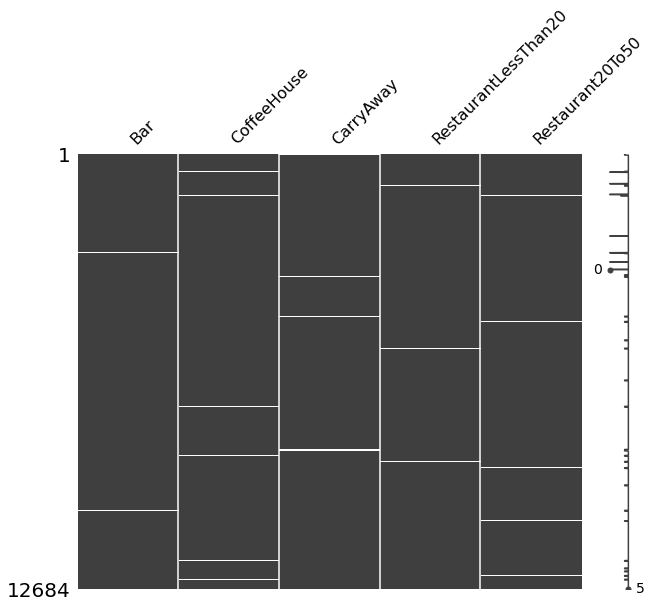

In [14]:
na_columns = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
na_df = df[na_columns]
msno.matrix(na_df, figsize=(10, 8))
plt.show()

From this matrix, we can probably say the missing values are at least missing at random. Let's do a correlation heatmap to ensure that.

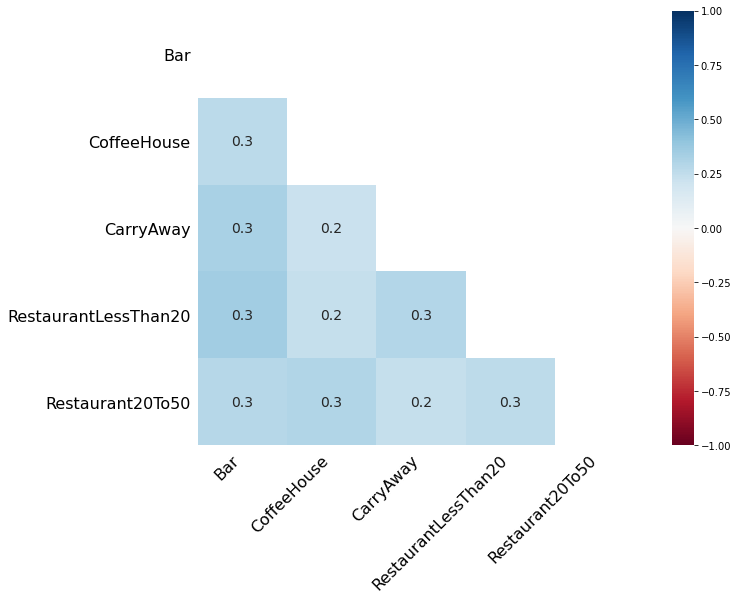

In [15]:
msno.heatmap(na_df, figsize=(10, 8));

Indeed, missing at random. So, we can do data imputation on them. Since we cannot directly impute data on the whole dataset, we are saving data imputation until we finished the data splitting. Before that, let's explore the dataset a little more.

In [16]:
df.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
df.select_dtypes('int64').nunique()

temperature          3
has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

Well, the column 'toCoupon_GEQ5min' has only one single value: 1. No variance at all, so, we can drop it. According to the dataset description, this column means driving distance to the restaurant/bar for using the coupon is greater than 5 minutes, so all the restaurant/bars are at least five minutes away from the driver.

**toCoupon_GEQ5min**

In [18]:
df.drop(columns=['toCoupon_GEQ5min'], inplace=True)

In [19]:
df.select_dtypes('object').nunique()

destination              3
passanger                4
weather                  3
time                     5
coupon                   5
expiration               2
gender                   2
age                      8
maritalStatus            5
education                6
occupation              25
income                   9
Bar                      5
CoffeeHouse              5
CarryAway                5
RestaurantLessThan20     5
Restaurant20To50         5
dtype: int64

In [20]:
for i in df.select_dtypes('object').columns:
    print(i, df[i].unique())

destination ['No Urgent Place' 'Home' 'Work']
passanger ['Alone' 'Friend(s)' 'Kid(s)' 'Partner']
weather ['Sunny' 'Rainy' 'Snowy']
time ['2PM' '10AM' '6PM' '7AM' '10PM']
coupon ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']
expiration ['1d' '2h']
gender ['Female' 'Male']
age ['21' '46' '26' '31' '41' '50plus' '36' 'below21']
maritalStatus ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
education ['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']
occupation ['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare Support'
 'Healthcare Practitioners & Technical' 'Sales & Related' 'Management'
 'Arts Design Entertainment Sports & Media' 'Computer & Mathematical'
 'Life Physical Social Science' 'Personal Care & Service'
 'Community & Social Services' 'Office & Administrative Support'
 'Constr

There are many levels in the **occupation** column. If simply apply onehotencoder on it, it will greatly increase the sparsity of our data.

Now, we have finished the basic data wrangling part, if other problems rises during exploratory data analysis, we can repeat the data wrangling process.

In [21]:
clean_df = df.copy()

## Exploratory Data Analysis

First, we plot the count plot of each categorical variable:

**Categorical Features**

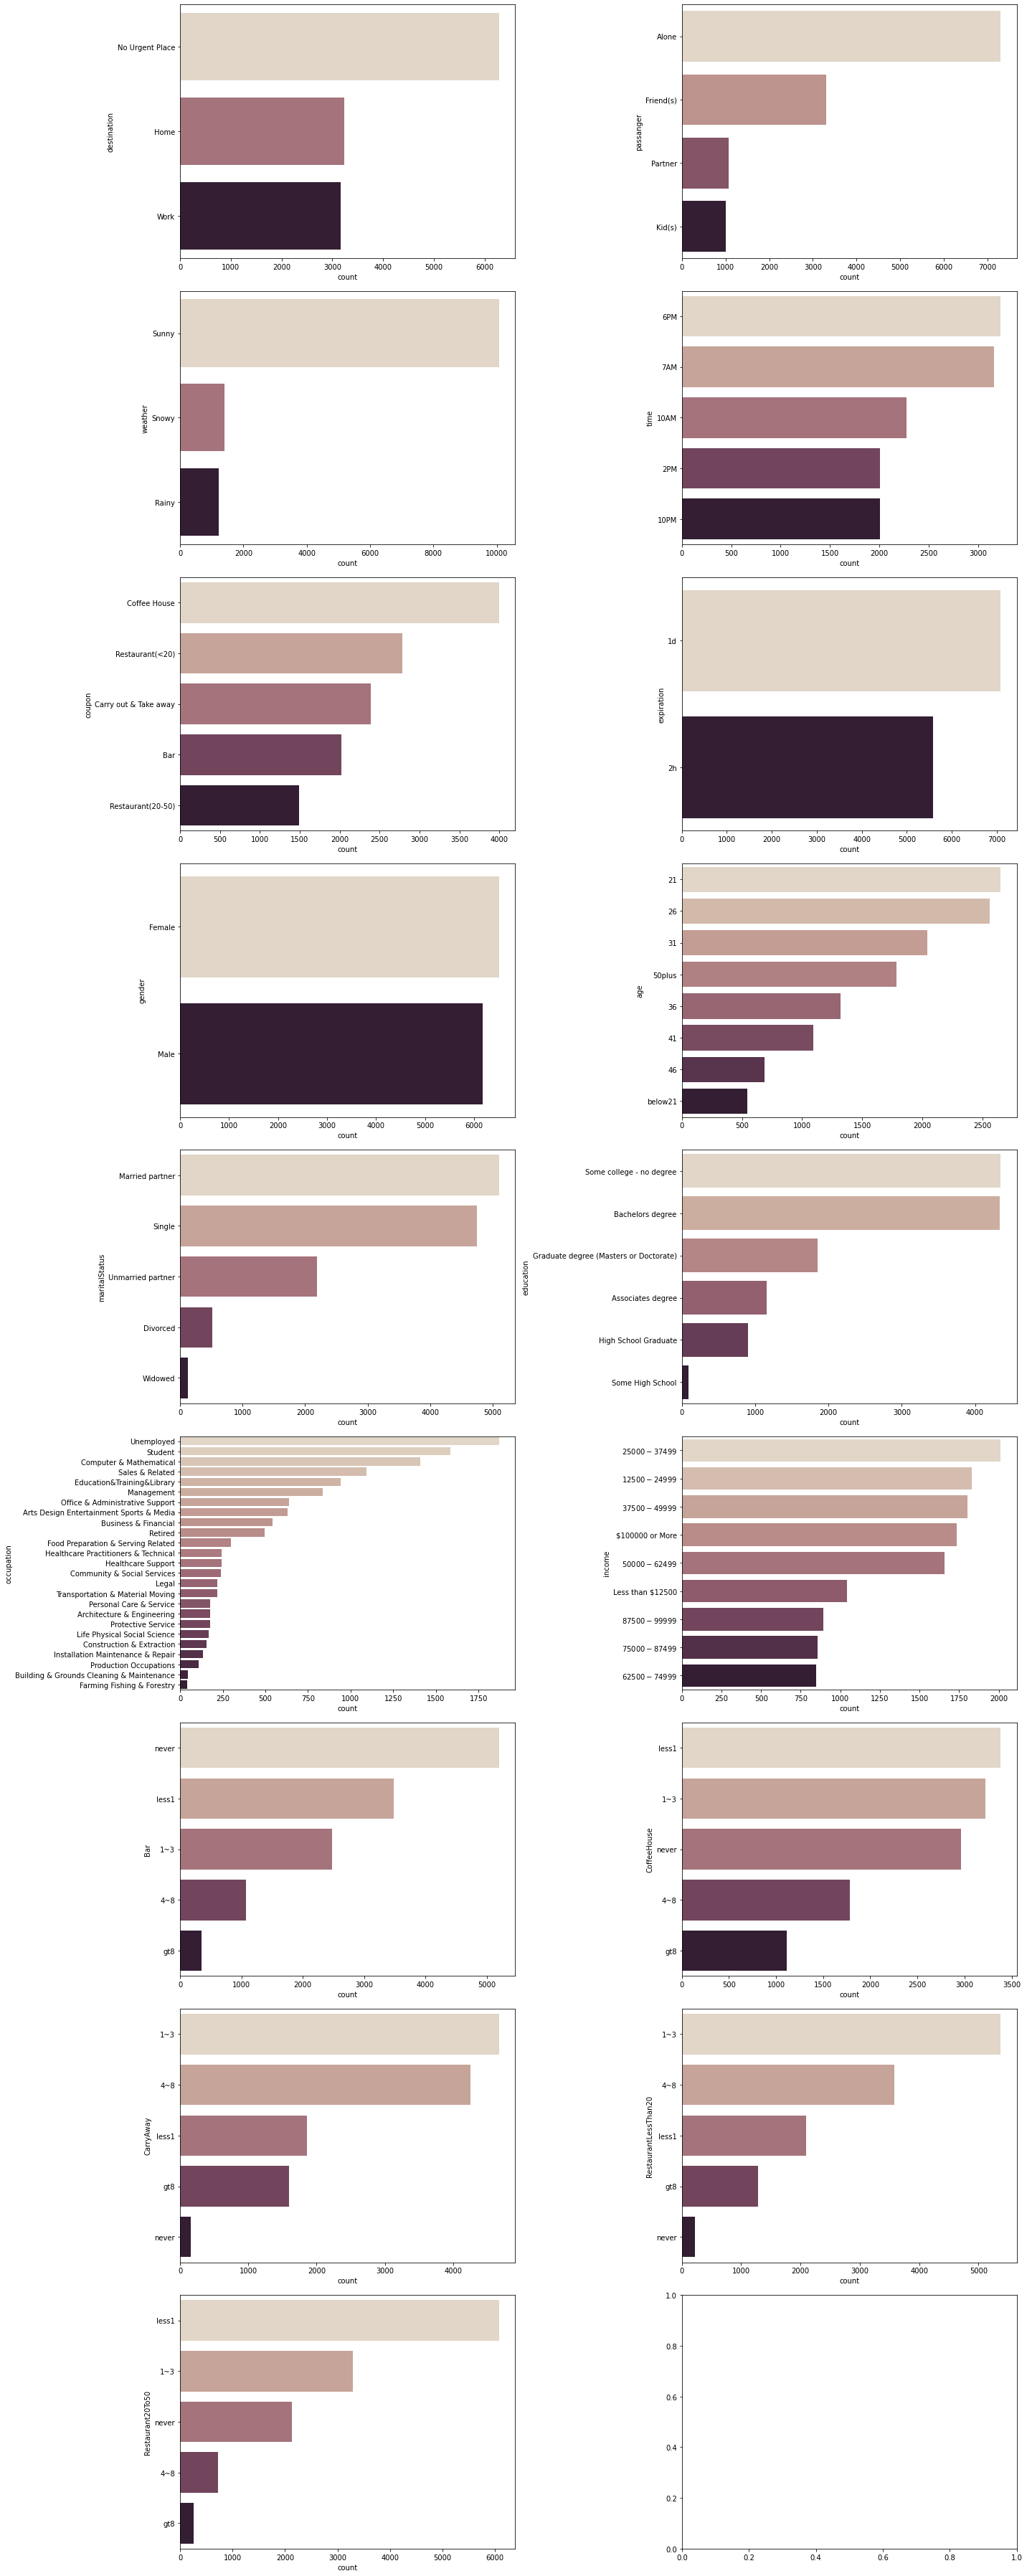

In [22]:
fig, axes = plt.subplots(9, 2, figsize=(20,50))
axes = axes.flatten()

for ax, col in zip(axes, clean_df.select_dtypes('object').columns):
    sns.countplot(y=col, data=clean_df, ax=ax, 
                  palette="ch:.25", order=clean_df[col].value_counts().index);

plt.tight_layout()
plt.show()

By looking at the counting plot of the categorical features, we realized that there are two kinds of categorical data: ordinal and nominal, we can apply one hot encoder to nominal features, however, ordinal data should be mapped into numerical data so that the inner order can preserve.

**Ordinal Features**

Those ordinal features are: 

* **Restaurant20To50**: how many times do you go to a restaurant with average expense per person of \\$20 - \\$50 every month?
* **RestaurantLessThan20**: how many times do you go to a restaurant with an average expense per person of less than \\$20 every month?
* **CarryAway**: how many times do you get take-away food every month?
* **CoffeeHouse**: how many times do you go to a coffeehouse every month?
* **age**: quite self-explanatory
* **Bar**: how many times do you go to bar every month?
* **income**: income range

Now, let's map them into numerical values with respect to their inner order:

In [23]:
frequency_map = {
    'never': 0,
    'less1': 1,
    '1~3': 2,
    '4~8': 3,
    'gt8': 4
}
age_map = {
    'below21': 0,
    '21': 1,
    '26': 2,
    '31': 3,
    '36': 4,
    '41': 5,
    '46': 6,
    '50plus': 7
}
income_map = {
    'Less than $12500': 0,
    '$12500 - $24999': 1,
    '$25000 - $37499': 2,
    '$37500 - $49999': 3,
    '$50000 - $62499': 4,
    '$62500 - $74999': 5,
    '$75000 - $87499': 6,
    '$87500 - $99999': 7,
    '$100000 or More': 8
}

In [24]:
frequency_cols = ['Restaurant20To50', 'RestaurantLessThan20', 
                  'CarryAway', 'CoffeeHouse', 'Bar']

In [25]:
for col in frequency_cols:
    clean_df[col] = clean_df[col].map(frequency_map)
clean_df.age = clean_df.age.map(age_map)
clean_df.income = clean_df.income.map(income_map)

**Nominal Features**

Now, let's have a look of the nominal features:

* **destination**: The destination of the driver
* **passenger**: Type of passenger in the car
* **weather**: Sunny, rainy, or snowy
* **time**: Current time
* **coupon**: Coupon type
* **expiration**: Coupon expiration time
* **gender**: Female or male
* **maritalStatus**: Marital status of the driver
* **occupation**: Occupation of the driver
* **education** Education level of the driver

Put occupation aside, let's plot the relationships between those features and the target feature.

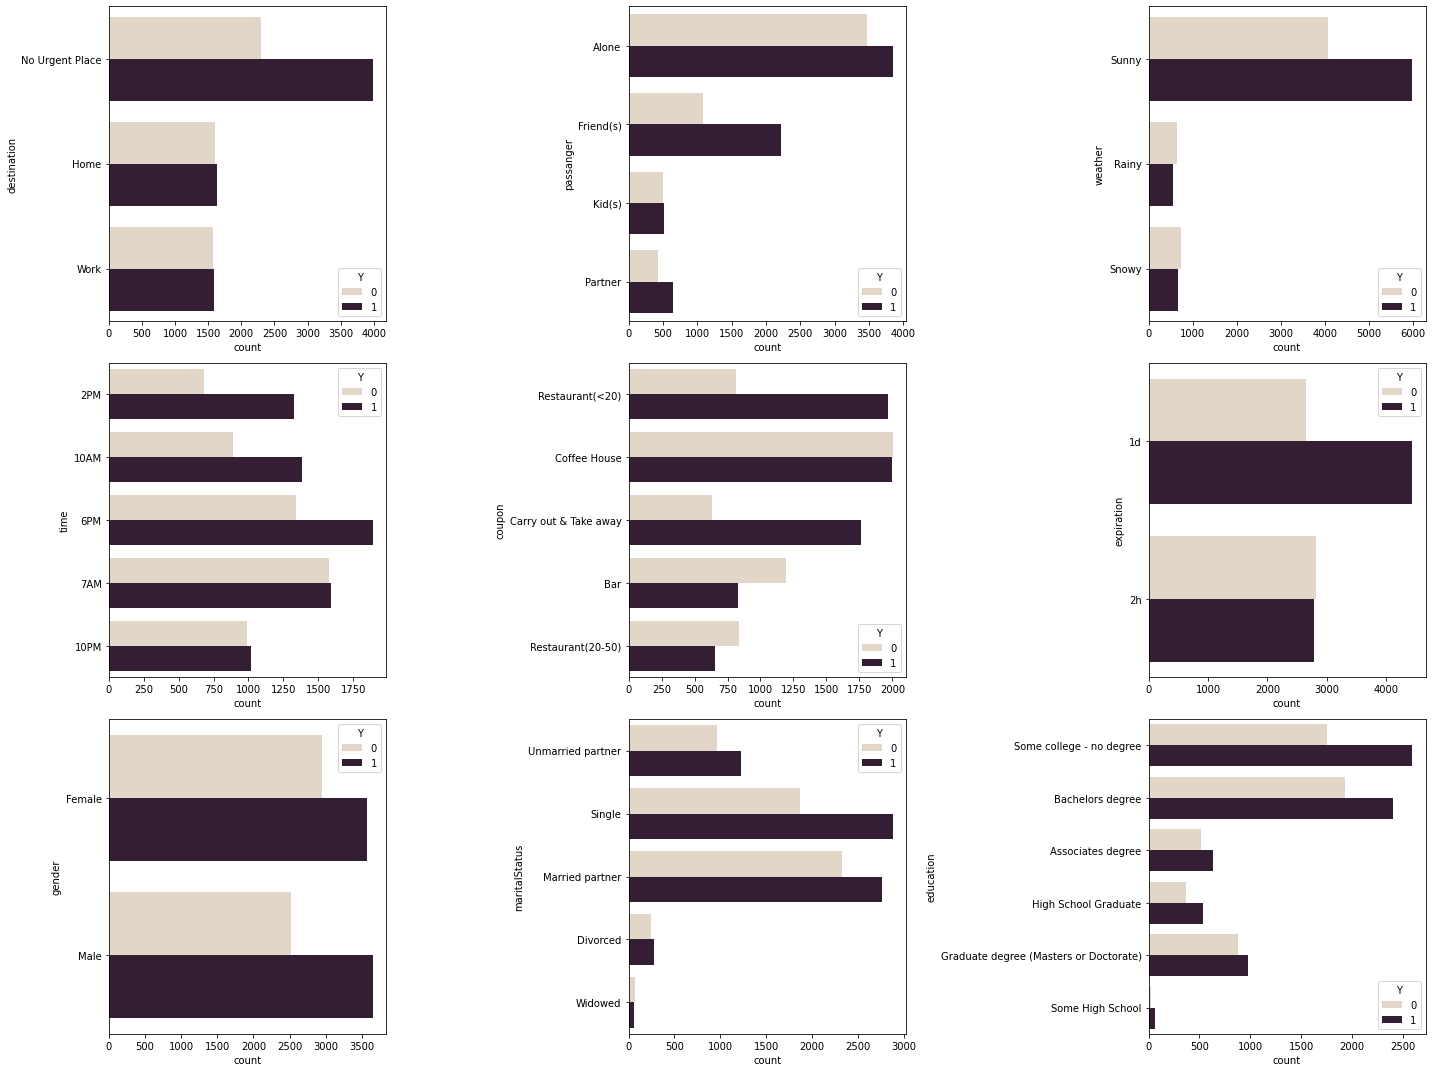

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for ax, col in zip(axes, ['destination', 'passanger', 'weather', 'time', 
                          'coupon', 'expiration', 'gender', 'maritalStatus',
                          'education']):
    sns.countplot(y=col, hue='Y', data=clean_df, ax=ax, palette='ch:.25')
plt.tight_layout()
plt.show()

* **destination** People that has no urgent place to go has a higher probability to accept the coupon.
* **passenger** If the passengers in car are friends of the driver, they are more likely to accept the coupon.
* **weather** People tend to accept the coupon when it is sunny.
* **time** If the time is too early or too late, the probability of accepting the coupon is lower.
* **coupon** If the coupon is of a coffee house, the probability of accepting the coupon is just the same as rejecting it. If the coupon is of a cheap restaurant or carry out, most people will accept the coupon. If the coupon is of a Bar of expensive Restaurant, people tend to refuse it.
* **expiration** People are more likely to accept a coupon that expires in one day than one in two hours.
* **gender** There is no much difference between gender.
* **maritalStatus** Single people are most likely to accept the coupon.
* **education** Some college, Bachelor or high school graduate are more likely to accept the coupon.

Now, let's look at the occupation feature:

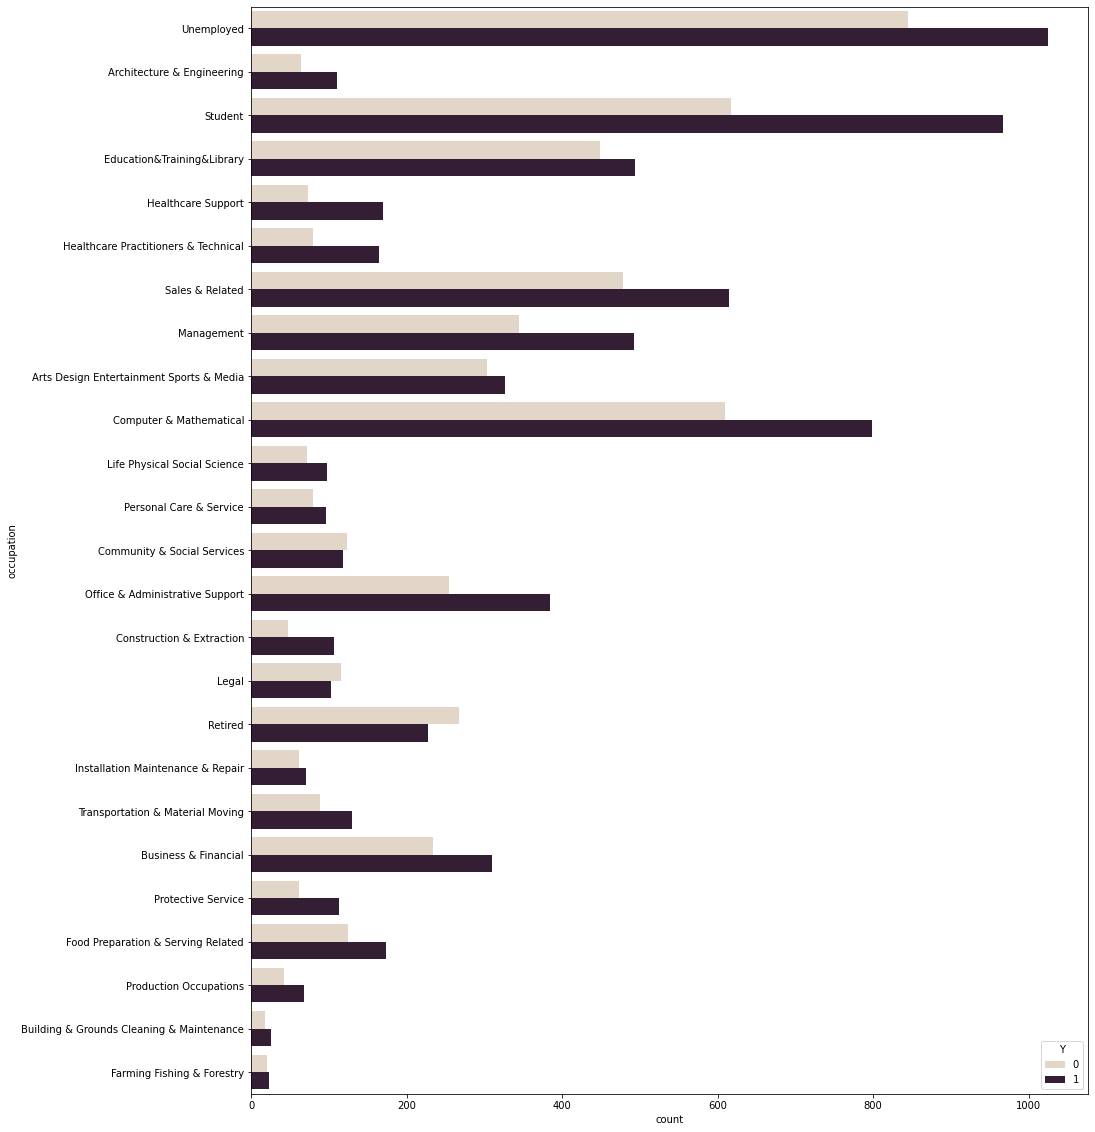

In [27]:
plt.subplots(figsize=(15, 20))
sns.countplot(y ='occupation', hue='Y', data=clean_df, palette='ch:.25');
plt.show()

This plot shows some differences among jobs. 

As a result, we think all those nominal features are strong predictor variables. Thus, we will do frequency encoding and target encoding on them to improve their predictive power. Those two encodings will be done after data splitting.

**Numerical Features**

We can check the correlations among all the numerical features now:

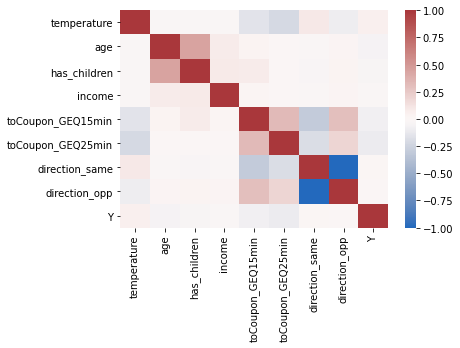

In [28]:
cmap = sns.color_palette('vlag', as_cmap=True)
sns.heatmap(clean_df.select_dtypes('int64', 'float64').corr(), cmap=cmap)
plt.show()

As the heatmap shows, there are two columns sharing the same information: **direction_same** and **direction_opp**. They indicate whether the restaurant/bar is in the same direction as your current destination. So we decide to delete the **direction_opp** column.

Besides, there are correlations among those frequency columns: **Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50**.

In [29]:
clean_df.drop(columns=['direction_opp'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


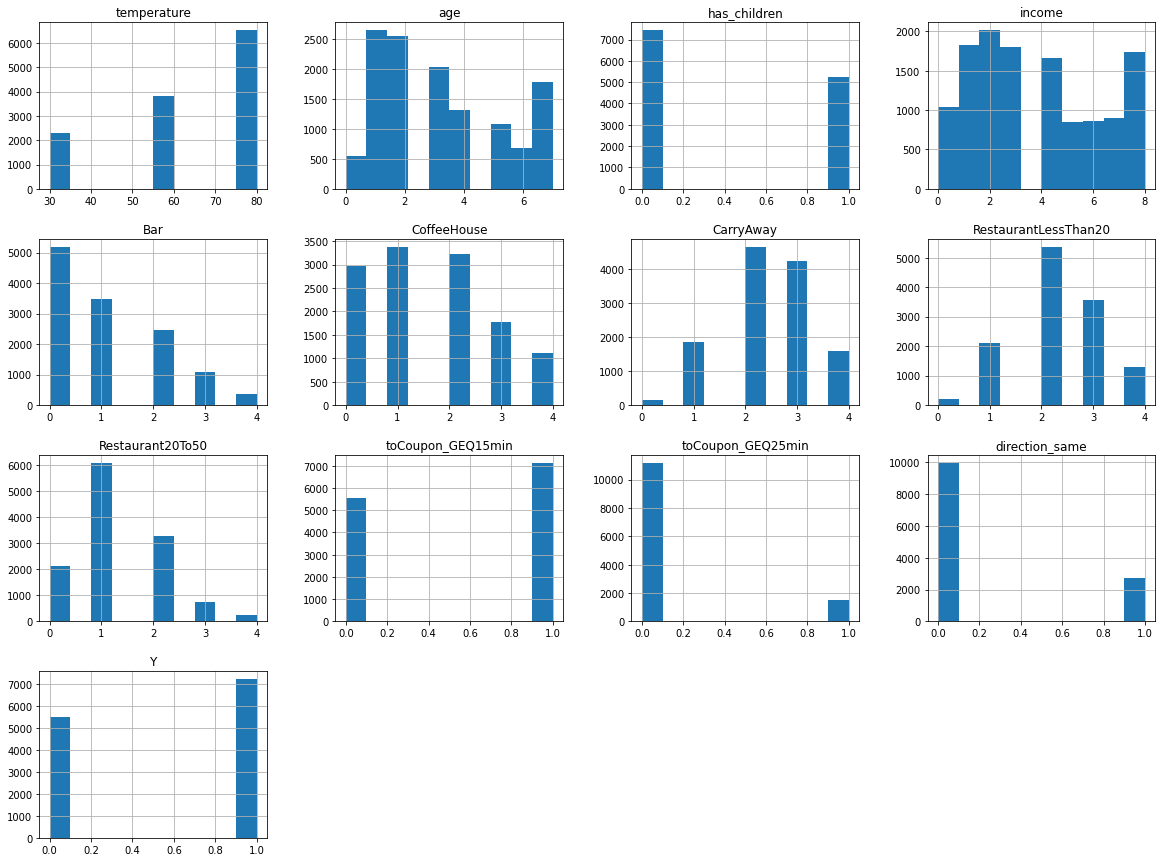

In [30]:
clean_df.hist(figsize=(20, 15))
plt.show()

**toCoupon_GEQ15min, toCoupon_GEQ25min**

After excluding the toCoupon_GEDQ5min feature, we see there are still two features about the driving distance to the Coupon's location: **toCoupon_GEQ15min** and **toCoupon_GEQ25min**. They have two possible values: 0 and 1 indicating yes or no to the question: is the driving distance to the restaurant/bar for using the coupon is greater than 15 minutes/25 minutes? We should be able to combine these two columns into one with ordinal data inside: greater than 5 minutes and less than 15 minutes, greater than 15 minutes and less than 25 minutes, and greater than 25 minutes. We believe doing that should be better than treat those two columns using onehotencoder just like different categories.

In [31]:
clean_df['distance'] = None
clean_df.loc[clean_df['toCoupon_GEQ15min'] == 0, 'distance'] = 0
clean_df.loc[(clean_df['toCoupon_GEQ15min'] == 1) & \
             (clean_df['toCoupon_GEQ25min'] == 0), 'distance'] = 1
clean_df.loc[clean_df['toCoupon_GEQ25min'] == 1, 'distance'] = 2
clean_df.distance.isna().sum()

0

In [32]:
clean_df.distance = clean_df.distance.astype('int64')
clean_df.distance.unique()

array([0, 1, 2])

In [33]:
clean_df.distance.value_counts()

1    5611
0    5562
2    1511
Name: distance, dtype: int64

Now we can drop these two columns: toCoupon_GEQ15min and toCoupon_GEQ25min

In [34]:
clean_df.drop(columns=['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], inplace=True)

In [35]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   destination           12684 non-null  object 
 1   passanger             12684 non-null  object 
 2   weather               12684 non-null  object 
 3   temperature           12684 non-null  int64  
 4   time                  12684 non-null  object 
 5   coupon                12684 non-null  object 
 6   expiration            12684 non-null  object 
 7   gender                12684 non-null  object 
 8   age                   12684 non-null  int64  
 9   maritalStatus         12684 non-null  object 
 10  has_children          12684 non-null  int64  
 11  education             12684 non-null  object 
 12  occupation            12684 non-null  object 
 13  income                12684 non-null  int64  
 14  Bar                   12577 non-null  float64
 15  CoffeeHouse        

Some columns needed to be transformed into categorical columns.

In [36]:
clean_df.has_children = clean_df.has_children.astype(str)
clean_df.direction_same = clean_df.direction_same.astype(str)

Let's have a look of the target feature:

In [37]:
clean_df.Y.value_counts()

1    7210
0    5474
Name: Y, dtype: int64

It's well balanced. Accuracy can be a good metric for model performance.

Let's explore relationships between some of the features and the target:

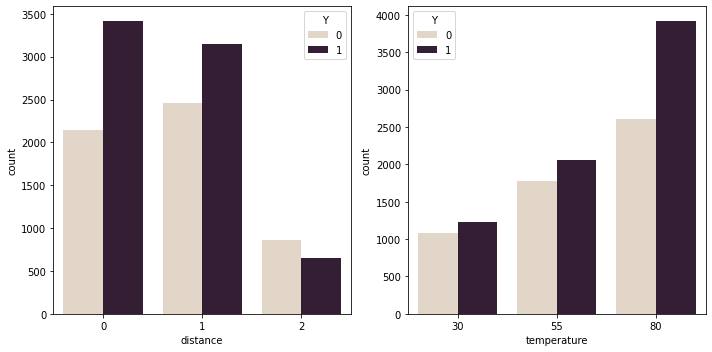

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

for ax, col in zip(axes, ['distance', 'temperature']):
    sns.countplot(x=col, hue='Y', data=clean_df, 
                  ax=ax, palette="ch:.25");

plt.tight_layout()
plt.show()

The plot shows some subtle, positive correlations between short distance, high temperature and the probability to accept the coupon.

Now, let's plot the correlations between numerical features:

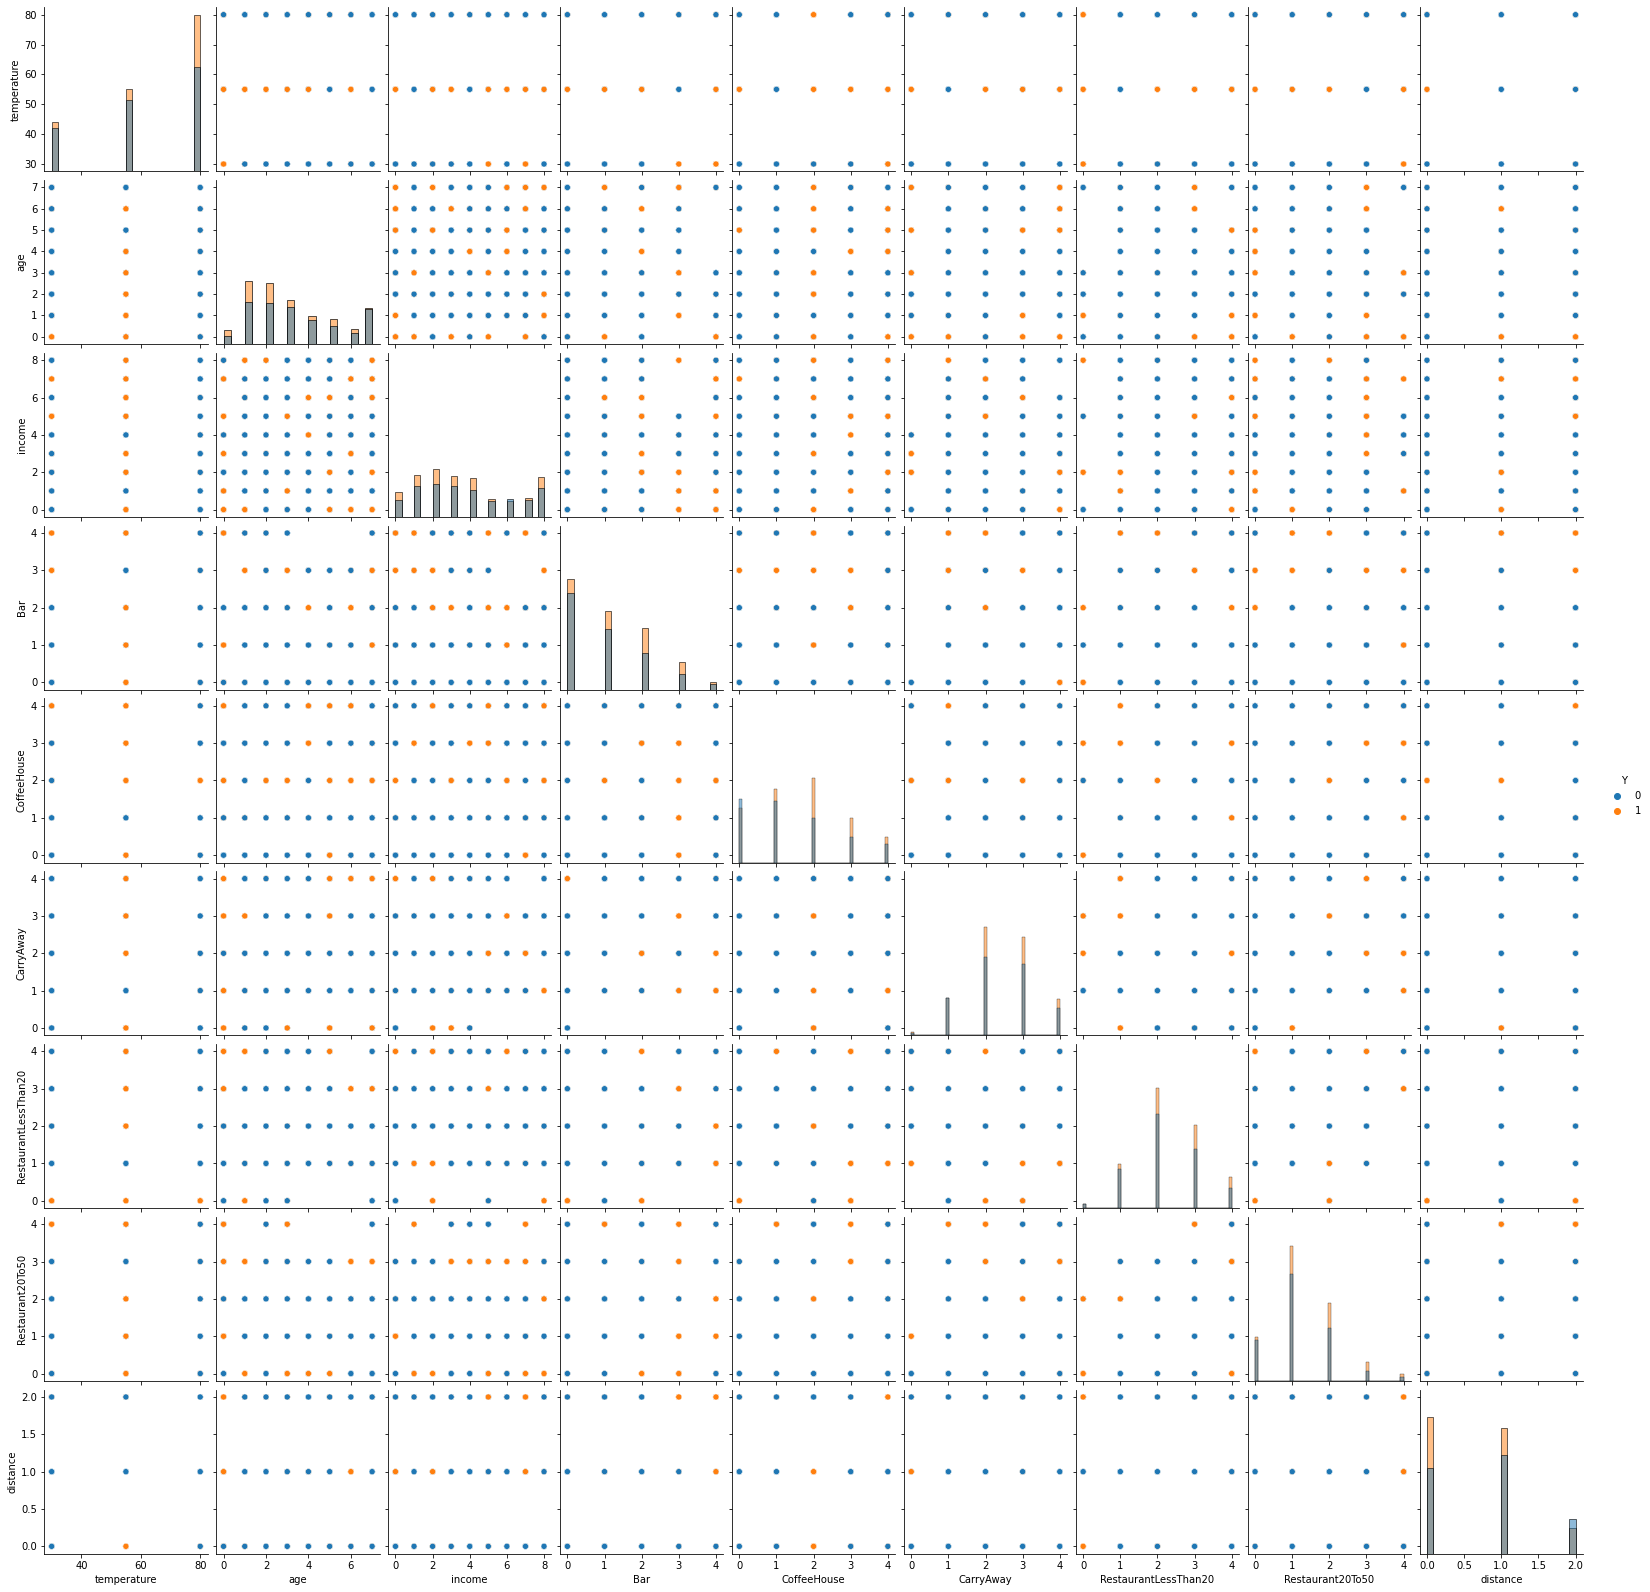

In [39]:
sns.pairplot(clean_df, hue='Y', diag_kind='hist')
plt.show()

The pair plot tells us one thing: how sparse our dataset is. All the numerical variables are discrete numbers, and actually categorical. If the numerical representation did not give a good result, we can treat all the variables as categorical and train models again.

If we look into the hist plot, we can see that there are more people accepting coupon than rejecting when temperature is high and when distance is short. It means temperature and distance are decent predictive variables.

In [40]:
clean_df.shape

(12684, 22)

Now, with 21 features, we are ready to train classification models on the cleaned dataset.

In [41]:
# Save the cleaned data set
clean_df.to_csv('clean_df.csv', index=False)

In [42]:
# Notice the values of have_children and direction_same are 0 and 1
# Thus, if not specified, the pd.read_csv() method will infer them as integer
# clean_df = pd.read_csv('/kaggle/working/clean_df.csv', 
#                        dtype={'has_children': str,
#                              'direction_same': str})

## Data Preprocessing

Based on the exploratory data analysis, we have almost all categorical variables. There are two sections of feature engineering we saved that can only be done with splitted data: imputation and categorical encoding.

* Data Imputation

We will use simple imputer to replace the missing value with the most frequent item.

* Categorical Encoding

For those categorical features we believe are strong predictors, we will do both frequency encoding and target encoding. For other categorical features, OneHotEncoder will be applied.

**Further Feature Engineering**

There are other considerations about the feature engineering:
* do we need to apply dimension reduction?

After the OneHotEncoding, we can predict the number of features to reach 50 or more, and the frequency columns are correlated, so it is possible to apply dimension reduction methods like PCA. 
* do we need to apply feature expansion?

We can use clustering method to add labels into the dataset as a new feature to help the classification task.

Those two considerations will be experimented in the model training process.

**Data Splitting**

In [43]:
X = clean_df.drop(columns=['Y'])
y = clean_df.Y
X_train, X_test, y_train, y_test = \
train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.2)

**Two Plans**

Here we want to compare the effects of different feature engineering: 
* **plan A** is to do frequency and target encoding for strong predictors we observed in EDA part, and OneHotEncoding for other categorical features. 
* **Plan B** is to apply OneHotEncoding for all the categorical features.

We will then compare the predictive performances of these two plans and decide which plan to keep for further tasks.

**Plan A**

In [44]:
X_train_a = X_train.copy()
X_test_a = X_test.copy()

**Frequency Encoding**

[Here](https://www.kaggle.com/bhavikapanara/frequency-encoding) is the reference for frequency encoding.

In [45]:
strong_predictors = ['destination', 'passanger', 'weather', 'time', 'coupon',
            'expiration', 'maritalStatus', 'education',
            'occupation', 'direction_same']
for col in strong_predictors:
    # create frequency encoder
    freq_encoder = X_train_a.groupby(col).size() / len(X_train_a)
    # fit_transform for X_train
    X_train_a[col + '_freq'] = X_train_a[col].apply(lambda x: freq_encoder[x])
    # transform for X_test
    X_test_a[col + '_freq'] = X_test_a[col].apply(lambda x: freq_encoder[x])

**K-fold Target Encoding**

The code below is borrowed from Pourya from his medium blog: [K-Fold Target Encoding](https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b). We added some docstrings and comments to make the code more readable. H2O has a great package named `TargetEncoder` which has basically the same workflow as Pourya's code, the tutorial can be found [here](http://h2o-release.s3.amazonaws.com/h2o/rel-yates/4/docs-website/h2o-docs/data-munging/target-encoding.html).

In [46]:
class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):
    """
    This object contains a target encoder for a training set which should have
    both X and y. 
    
    Arguments
    ---------
    feature:          string. Name of the feature in the training set.
    target:           string. Name of the target in the training set.
    n_fold:           default 5. Number of folds to use in KFold.
    verbose:          bool, default True. If set to True, the correlation between the 
                      feature and the target will be calculated and printed out.
    discard_original: bool,, default False. If set to True, the feature column will be 
                      deleted from the training set.
                      
    Example
    ---------
    train_target_encoder = KFoldTargetEncoderTrain(feature='A', target='target')
    new_train = train_target_encoder.fit_transform(train)
    """
    def __init__(self, feature, target, n_fold=5, verbose=True, discard_original=False):

        self.feature = feature
        self.target = target
        self.n_fold = n_fold
        self.verbose = verbose
        self.discard_original = discard_original

    def fit(self, X, y=None):
        return self

    def transform(self,X):
        """
        Transform the original training set. Notice this function can only encode 
        one feature once.
        
        Arguments:
        ----------
        X: A pandas DataFrame which should include both the feature and the target.
        
        Output:
        X: A pandas DataFrame with the target encoding.
        """
        
        # notice this function can only encode one feature at a time
        assert(type(self.feature) == str)
        assert(type(self.target) == str)
        assert(self.feature in X.columns)
        assert(self.target in X.columns)

        mean_of_target = X[self.target].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = True, random_state=RANDOM_SEED)
        # create the target encoding
        col_mean_name = self.feature + '_target'
        X[col_mean_name] = np.nan

        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            X.loc[X.index[val_index], col_mean_name] = \
            X_val[self.feature].map(X_train.groupby(self.feature)[self.target].mean())
        # missing value imputation
        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbose:
            encoded_feature = X[col_mean_name].values
            print('Correlation between {} and, {} is {}.'.\
                  format(col_mean_name, self.target,
                         np.corrcoef(X[self.target].values, encoded_feature)[0][1]))
        # discard orginal feature column if needed
        if self.discard_original:
            X = X.drop(self.target, axis=1)

        return X

In [47]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    """
    This object contains a target encoder for a testing set which should have
    both X and y.
    
    Arguments
    ---------
    train:          pandas DataFrame. The training DataFrame with the feature and 
                    the target encoded column of it.
    feature:        string. The column name of the feature.
    feature_target: string. The column name of the feature_target that 
                    has been calculated in the training set.
                    
    Example
    ---------
    test_target_encoder = KFoldTargetEncoderTest(new_train, 'A', 'A_target')
    new_test = test_target_encoder.transform(test)
    """
    
    def __init__(self, train, feature, feature_target):
        
        self.train = train
        self.feature = feature
        self.feature_target = feature_target
        
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        """
        Transform the testing set based on K-fold target encoder of the training set.
        Notice this function can only encode one feature at a time.
        
        Argument
        --------
        X: pandas DataFrame. The testing set to be transformed.
        
        Output
        --------
        X: A pandas DataFrame with transformed target encoding.
        """

        mean = self.train[[self.feature,self.feature_target]].groupby(self.feature).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.feature]] = row[self.feature_target]

        
        X[self.feature_target] = X[self.feature]
        X = X.replace({self.feature_target: dd})

        return X

In [48]:
train_df = pd.concat([X_train_a, y_train], axis=1)
new_train = train_df.copy()
for feature in strong_predictors:
    train_target_encoder = KFoldTargetEncoderTrain(feature, 'Y')
    new_train = train_target_encoder.fit_transform(new_train)

Correlation between destination_target and, Y is 0.12364956917287118.
Correlation between passanger_target and, Y is 0.1268845914437205.
Correlation between weather_target and, Y is 0.09771104177149836.
Correlation between time_target and, Y is 0.1146459984755344.
Correlation between coupon_target and, Y is 0.26883634354389313.
Correlation between expiration_target and, Y is 0.12801533929734007.
Correlation between maritalStatus_target and, Y is 0.05486779778923601.
Correlation between education_target and, Y is 0.05043521568933238.
Correlation between occupation_target and, Y is 0.08442336642116348.
Correlation between direction_same_target and, Y is 0.010808622009684563.


According to the correlations between those categorical features and the target, the strong predictors (correlation $\ge$ 0.1) are **destination, passanger, weather, time, coupon,** and **expiration.** Although not all of the features in the `strong_predictors` list are really strong predictors, we still want to implement the frequency encoding and feature encoding on them because it can greatly reduce the dimensions of the dataset.

In [49]:
test_df = pd.concat([X_test_a, y_test], axis=1)
new_test = test_df.copy()
strong_predictors_targets = []
for feature in strong_predictors:
    strong_predictors_targets.append(feature + '_target')
for feature, feature_target in zip(strong_predictors, strong_predictors_targets):
    test_target_encoder = KFoldTargetEncoderTest(new_train, feature, feature_target)
    new_test = test_target_encoder.transform(new_test)

In [50]:
new_train.drop(columns=strong_predictors, inplace=True)
new_test.drop(columns=strong_predictors, inplace=True)

In [51]:
X_train_a = new_train.drop(columns=['Y'])
X_test_a = new_test.drop(columns=['Y'])

In [52]:
X_train_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10147 entries, 3956 to 9332
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temperature            10147 non-null  int64  
 1   gender                 10147 non-null  object 
 2   age                    10147 non-null  int64  
 3   has_children           10147 non-null  object 
 4   income                 10147 non-null  int64  
 5   Bar                    10062 non-null  float64
 6   CoffeeHouse            9972 non-null   float64
 7   CarryAway              10018 non-null  float64
 8   RestaurantLessThan20   10049 non-null  float64
 9   Restaurant20To50       9995 non-null   float64
 10  distance               10147 non-null  int64  
 11  destination_freq       10147 non-null  float64
 12  passanger_freq         10147 non-null  float64
 13  weather_freq           10147 non-null  float64
 14  time_freq              10147 non-null  float64
 15  

**Other Data Preprocessing**

Here we used sklearn's `Pipeline` and `ColumnTransformer` to do simple imputation, standardization, and one hot encoder for columns of mixed data types. The tutorial of how to use `Pipeline` and `ColumnTransformer` can be found [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html).

In [53]:
num_features_a = X_train_a.select_dtypes(['int64', 'float64']).columns
cat_features_a = X_train_a.select_dtypes(['object']).columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])
cat_transformer = OneHotEncoder()
preprocessor_a = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features_a),
    ('cat', cat_transformer, cat_features_a)
])
X_train_a = preprocessor_a.fit_transform(X_train_a)
X_test_a = preprocessor_a.transform(X_test_a)

In [54]:
X_train_a.shape, X_test_a.shape

((10147, 33), (2537, 33))

After data preprocessing, we now have 33 features in plan A. Now, we can do data preprocessing for plan B, which basically uses `OneHotEncoder` for all categorical features.

**Plan B**

In [55]:
X_train_b = X_train.copy()
X_test_b = X_test.copy()

In [56]:
num_features_b = X_train_b.select_dtypes(['int64', 'float64']).columns
cat_features_b = X_train_b.select_dtypes(['object']).columns

preprocessor_b = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features_b),
    ('cat', cat_transformer, cat_features_b)
])
X_train_b = preprocessor_b.fit_transform(X_train_b)
X_test_b = preprocessor_b.transform(X_test_b)

In [57]:
X_train_b.shape, X_test_b.shape

((10147, 73), (2537, 73))

Now, we have both kinds of data: plan A with frequency encoding and target encoding, plan B with one hot encoding. We will next build basic models on them and check the performance between plan A and B.

# Model Training

## Basic Models

The basic models we picked are Logistic Regression, Decision Tree, Naive Bayes, K Nearest Neighbor, and linear Support Vector Machine. We picked those models because they are fast to train. We will use `RandomizedSearchCV` to choose hyperparameters from the same parameter grid for both plan A and plan B. After that, we will compare the results of them.

Tutorial for `RandomizedSearchCV` can be found [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py). We also borrowed Rupanjan Nayak's [code](https://stackoverflow.com/questions/23045318/scikit-grid-search-over-multiple-classifiers) to train multiper models at once.

**Plan A**

Classifiers:

In [58]:
logreg_clf = LogisticRegression(solver='saga', max_iter=500,
                               random_state=RANDOM_SEED)
dt_clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
bnb_clf = BernoulliNB()
knn_clf = KNeighborsClassifier()
lsvm_clf = LinearSVC(max_iter=5000, dual=False)

Parameter distributions:

In [59]:
logreg_params = dict(C=loguniform(1e-1, 1e2),
                     penalty=['l1', 'l2'])
dt_params = dict(criterion=['gini', 'entropy'],
                 min_samples_split=[2, 4, 6, 8, 10],
                 max_depth=[2, 4, 6, 8, 10])
bnb_params = dict(alpha=loguniform(1e-1, 1e0))
knn_params = dict(n_neighbors=[2, 4, 6, 8, 10, 12, 14, 20],
               weights=['uniform', 'distance'],
               metric=['euclidean', 'manhattan'])
lsvm_params = dict(C=loguniform(1e-1, 1e2))

In [60]:
clf_list = [logreg_clf, dt_clf, bnb_clf, knn_clf, lsvm_clf]
params_list = [logreg_params, dt_params, bnb_params, knn_params, lsvm_params]
model_names = ['Logistic Regression', 'Decison Tree', 'Bernoulli Naive Bayes',
               'KNN Classifier', 'Linear SVM']

In [61]:
def train_model(X, y, model_suffix, clf_list=clf_list, params_list=params_list):
    for i in range(len(clf_list)):
        # model training with RandomizedSearchCV
        rscv = RandomizedSearchCV(estimator=clf_list[i],
                                  param_distributions=params_list[i],
                                  n_jobs=-1, random_state=RANDOM_SEED).fit(X, y)
        # store cv results
        globals()['rscv%s' % model_suffix[i]] = pd.DataFrame(rscv.cv_results_)
        # store the best model
        globals()['best%s' % model_suffix[i]] = rscv

In [62]:
def record_best_result(model_list, model_suffix):
    # store the best results into a dataframe
    for i in range(len(model_list)):
        globals()['df%s' % model_suffix[i]] = model_list[i].query('rank_test_score == 1')\
        [['params', 'mean_test_score', 'std_test_score']]

In [63]:
def model_eval(clf_list, model_names, X_test, y_test):
    test_acc = []
    f1_score = []
    for clf in clf_list:
        test_acc.append(clf.score(X_test, y_test))
        f1_score.append(metrics.f1_score(y_test, clf.predict(X_test)))
    return pd.DataFrame(data={'model': model_names, 'test_acc': test_acc, 'f1_score': f1_score})

In [64]:
# train models
model_suffix_a = ['_logreg_a', '_dt_a', '_bnb_a', '_knn_a', '_lsvm_a']
train_model(X_train_a, y_train, model_suffix_a)

# record best results in cross validation
rscv_list_a = [rscv_logreg_a, rscv_dt_a, rscv_bnb_a, rscv_knn_a, rscv_lsvm_a]
record_best_result(rscv_list_a, model_suffix_a)

# output the best results as a dataframe
df_list_a = [df_logreg_a, df_dt_a, df_bnb_a, df_knn_a, df_lsvm_a]
for df, model in zip(df_list_a, model_names):
    df['model'] = model
result_df_a = pd.concat(df_list_a)

# check test scores
best_clfs_a = [best_logreg_a, best_dt_a, best_bnb_a, best_knn_a, best_lsvm_a]
test_result_a = model_eval(best_clfs_a, model_names, X_test_a, y_test)

In [65]:
result_df_a

,params,mean_test_score,std_test_score,model
4,"{'C': 0.344333532380571, 'penalty': 'l1'}",0.679512,0.004127,Logistic Regression
3,"{'min_samples_split': 2, 'max_depth': 6, 'criterion': 'entropy'}",0.695871,0.005037,Decison Tree
4,{'alpha': 0.9936725240317664},0.646104,0.007718,Bernoulli Naive Bayes
6,"{'weights': 'distance', 'n_neighbors': 12, 'metric': 'manhattan'}",0.718636,0.003079,KNN Classifier
4,{'C': 98.11374296188326},0.680103,0.004883,Linear SVM


In [66]:
test_result_a

,model,test_acc,f1_score
0,Logistic Regression,0.670083,0.721093
1,Decison Tree,0.696098,0.749757
2,Bernoulli Naive Bayes,0.653528,0.701731
3,KNN Classifier,0.733149,0.777522
4,Linear SVM,0.669294,0.720240


**Plan B**

Train those models again on data of plan B:

In [67]:
# train models
model_suffix_b = ['_logreg_b', '_dt_b', '_bnb_b', '_knn_b', '_lsvm_b']
train_model(X_train_b, y_train, model_suffix_b)

# record best results in cross validation
rscv_list_b = [rscv_logreg_b, rscv_dt_b, rscv_bnb_b, rscv_knn_b, rscv_lsvm_b]
record_best_result(rscv_list_b, model_suffix_b)

# output the best results as a dataframe
df_list_b = [df_logreg_b, df_dt_b, df_bnb_b, df_knn_b, df_lsvm_b]
for df, model in zip(df_list_b, model_names):
    df['model'] = model
result_df_b = pd.concat(df_list_b)

# check test scores
best_clfs_b = [best_logreg_b, best_dt_b, best_bnb_b, best_knn_b, best_lsvm_b]
test_result_b = model_eval(best_clfs_b, model_names, X_test_b, y_test)

In [68]:
result_df_b

,params,mean_test_score,std_test_score,model
4,"{'C': 0.344333532380571, 'penalty': 'l1'}",0.679807,0.001395,Logistic Regression
1,"{'min_samples_split': 10, 'max_depth': 8, 'criterion': 'gini'}",0.695672,0.013751,Decison Tree
0,{'alpha': 0.40362520519080136},0.655268,0.010011,Bernoulli Naive Bayes
1,{'alpha': 0.5412144223247399},0.655268,0.010011,Bernoulli Naive Bayes
7,{'alpha': 0.5661420703684213},0.655268,0.010011,Bernoulli Naive Bayes
8,{'alpha': 0.4593677628057311},0.655268,0.010011,Bernoulli Naive Bayes
6,"{'weights': 'distance', 'n_neighbors': 12, 'metric': 'manhattan'}",0.714594,0.010974,KNN Classifier
5,{'C': 0.24237461166526628},0.678230,0.002283,Linear SVM


In [69]:
test_result_b

,model,test_acc,f1_score
0,Logistic Regression,0.669689,0.721595
1,Decison Tree,0.705164,0.750833
2,Bernoulli Naive Bayes,0.657864,0.701308
3,KNN Classifier,0.721719,0.767916
4,Linear SVM,0.670871,0.722130


In [70]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_result_a.model, y=test_result_a.test_acc,
                         mode='lines+markers', name='testing accuracy of plan A'))
fig.add_trace(go.Scatter(x=test_result_b.model, y=test_result_b.test_acc,
                         mode='lines+markers', name='testing accuracy of plan B'))
fig.update_layout(title={'text': 'Testing Accuracy of Basic Models',
                         'y': 0.9,
                         'x': 0.4,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

In [71]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_result_a.model, y=test_result_a.f1_score,
                         mode='lines+markers', name='testing f1 score of plan A'))
fig.add_trace(go.Scatter(x=test_result_b.model, y=test_result_b.f1_score,
                         mode='lines+markers', name='testing f1 score of plan B'))
fig.update_layout(title={'text': 'Testing F1 Scores of Basic Models',
                         'y': 0.9,
                         'x': 0.4,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

From the visualizations, we can see that the knn classifier built on data of plan A has a better accuracy. This is quite interpretable since knn classifier relies on distances, and our feature engineering in plan A transformed sparse categorical data into numerical frequency features, by doing that, distance among the feature space started to make more sense. 

Decision tree built on data of plan B performs better than plan A, that is because decision tree is good at splitting categorical data, so one hot encoded features are more suitable for decision tree. 

As for F1 scores, knn classifier reached the highest testing F1 score on data of plan A, indicating the best overall predictive accuracy behind it.

To improve the prediction results, we have two directions to explore: 
* Feature Expansion

We can use clustering method to cluster the training data and add the cluster label as new feature.

* Advanced Models

Advanced models like Random Forest, kernel SVM, Neural Networks, and Gradient Boosting Machine can be applied.

## Feature Expansion

Two popular clustering methods can be used to apply feature expansion: hierarchical clustering and k-means clustering. However, hierarchical clustering is slower than k-means clustering, thus, we are using k-means for this feature expansion task.

### K-prototypes Clustering

Since we have mixed data types, K-means is not appropriate here because Euclidean distance is meaningless for categorical data. There are two variations of K-means clustering: K-modes is capable of clustering on categorical data, K-prototypes clustering is suitable for mixed data types. Both of them are encapsulated in [**kmodes**](https://github.com/nicodv/kmodes) module. The original paper of K-prototypes clustering by Huang can be found [here](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.94.9984), another version of k-prototypes by Cao et al. can be found [here](http://www.jiyeliang.net/Cms_Data/Contents/SXU_JYL/Folders/JournalPapers/~contents/TW82GXVHZCGNRBPV/A%20new%20initialization%20method%20for%20categorical%20data%20clustering.pdf).

There is a concern for the clustering algorithm: to include the target feature or not. If we include the target to get the cluster labels, and use those labels to classify the target, the information about target will have leaked into the features, and the accuracy will be overly optimisitc. But when we evaluate them on the test set, this bias will diminish and disappear. Thus, we can also use k-fold cross validation to alleviate the data leakage problem.

To use k-prototypes, we need to point out the column indices of categorical features. After using sklearn's preprocessor, the column names and indices have changed. So, we need to figure them out for data plan A and B.

In [72]:
scale_features_a = list(preprocessor_a.transformers_[0][2])
onehot_features_a = list(preprocessor_a.transformers_[1][1].get_feature_names(list(cat_features_a)))
onehot_indices_a = list(range(len(preprocessor_a.transformers_[0][2]), 
                                  X_train_a.shape[1]))

In [73]:
scale_features_b = list(preprocessor_b.transformers_[0][2])
onehot_features_b = list(preprocessor_b.transformers_[1][1].get_feature_names(list(cat_features_b)))
onehot_indices_b = list(range(len(preprocessor_b.transformers_[0][2]), 
                                  X_train_b.shape[1]))

To determine which number of clusters to use in the K-prototypes clustering, we plotted a silhouette diagram:

* Plan A

In [74]:
train_kprot_a = np.hstack((X_train_a, y_train[:, np.newaxis]*5.0))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [75]:
kprot_runs_a = [KPrototypes(n_clusters=k, random_state=RANDOM_SEED, n_jobs=-1).\
                fit(train_kprot_a, categorical=onehot_indices_a)
                for k in range(1, 11)]

In [76]:
def plot_silhouette(X_train, kprot_runs):
    silhouette_scores = [silhouette_score(X_train, model.labels_) 
                         for model in kprot_runs[1:]]
    
    plt.figure(figsize=(15, 20))
    for k in range(2, 10):
        plt.subplot(4, 2, k - 1)

        y_pred = kprot_runs[k - 1].labels_
        silhouette_coefficients = silhouette_samples(X_train, y_pred)

        padding = len(X_train) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        if k in (2, 4, 6, 8):
            plt.ylabel("Cluster")

        if k in (8, 9):
            plt.xlabel("Silhouette Coefficient")

        plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=16)

    plt.show()

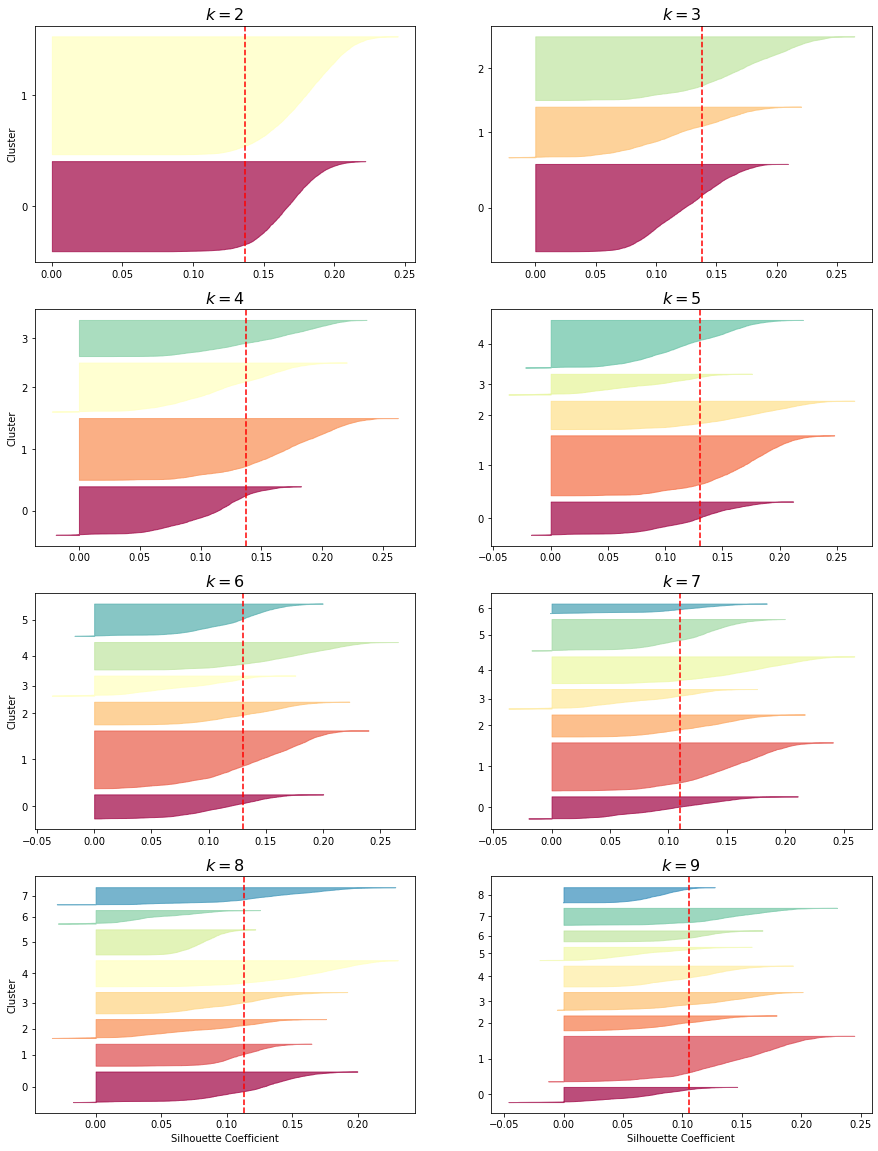

In [77]:
plot_silhouette(train_kprot_a, kprot_runs_a)

Silhouette coefficient ranges from -1 to +1, the silhouette score is the mean silhouette coefficient over all the instances within the cluster. A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to –1 means that the instance may have been assigned to the wrong cluster.

According to the silhouette plot for data plan A, the silhouette score looks good when $k = 2, 3, 4, 5$ as the red dashed line indicates the average silhouette score. We are picking $k = 4$ as the number of clusters of our k-prototypes clustering for data in plan A.

* Plan B

Due to sparsity and the curse of dimension, k-prototypes model on data of plan B will take more than 1 hour to train for plotting the silhouette plot. Thus, we give it up. The feature expansion will only be applied on data in plan A.

Now, it's time to implement the k-prototypes algorithm for feature expansion:

In [78]:
class KProtFeaturizer:
    """
    Transforms mixed data into k-prototypes cluster.
    
    This transformer runs k-prototypes on the input data and converts each data
    point into the ID of the closest cluster. If a target variable is present, 
    it is scaled and included as input to k-prototypes in order to derive clusters
    that obey the classification boundary as well as group similar points together.
    """
    
    def __init__(self, k=15, target_scale=5.0, 
                 categorical=None,
                 random_state=RANDOM_SEED):
        self.k = k
        self.target_scale = target_scale
        self.categorical = categorical
        self.random_state = random_state
        
    def fit(self, X, y=None):
        """Runs k-prototypes on the input data and finds centroids."""
        
        if y is None:
            # No target variable, just do plain k-prototypes
            kprot_model = KPrototypes(n_clusters=self.k,
                                      n_jobs=-1,
                                      random_state=self.random_state)
            kprot_model.fit(X, categorical=self.categorical)
            
            self.kprot_model = kprot_model
            self.cluster_centroids_ = kprot_model.cluster_centroids_
            return self
        
        # There is target information. Apply approrpriate scaling and include
        # it in the input data to k-prototypes.
        data_with_target = np.hstack((X, y[:, np.newaxis] * self.target_scale))
        
        # Build a pre-training k-prototypes model on data and target
        kprot_model_pretrain = KPrototypes(n_clusters=self.k,
                                           n_jobs=-1,
                                           random_state=self.random_state)
        kprot_model_pretrain.fit(data_with_target, categorical=self.categorical)
        
        # Run k-prototypes a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training. 
        # Go through a single iteration of cluster assignment and centroid recomputation.
        kprot_model = KPrototypes(n_clusters=self.k,
                                  # For KPrototypes, we need to specify the cluster centroids for 
                                  # numerical and categorical columns, notice that the numerical 
                                  # part should exclude the target info
                                  init=[kprot_model_pretrain.cluster_centroids_[:, \
                                  [i for i in range(kprot_model_pretrain.cluster_centroids_.shape[1] - 1)\
                                  if i not in self.categorical]],\
                                  kprot_model_pretrain.cluster_centroids_[:, self.categorical]],
                                  n_init=1,
                                  max_iter=1)
        kprot_model.fit(X, categorical=self.categorical)
        
        self.kprot_model = kprot_model
        self.cluster_centroids_ = kprot_model.cluster_centroids_
        return self
    
    def transform(self, X, y=None):
        """Outputs the closest cluster ID for each input data point.
        """
        clusters = self.kprot_model.predict(X, categorical=self.categorical)
        return clusters[:, np.newaxis]
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    

In [79]:
# apply the featurizer
kprot_a = KProtFeaturizer(k=4, target_scale=5.0, 
                          categorical=onehot_indices_a,
                          random_state=RANDOM_SEED)
train_cluster_a = kprot_a.fit_transform(X_train_a, y_train)
test_cluster_a = kprot_a.transform(X_test_a)
# use one-hot encoder to record the cluster labels
enc = OneHotEncoder()
# Notice that after one-hot encoding, the outcome matrix
# is a sparse matrix, we need to transform to an ndarray
train_cluster_label_a = enc.fit_transform(train_cluster_a).toarray()
test_cluster_label_a = enc.transform(test_cluster_a).toarray()
X_train_kprot_a = np.hstack((X_train_a, train_cluster_label_a))
X_test_kprot_a = np.hstack((X_test_a, test_cluster_label_a))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



## Retrain Models after Adding Cluster Labels

In [80]:
# train models
model_suffix_kprot = ['_logreg_kprot', '_dt_kprot', '_bnb_kprot', '_knn_kprot', '_lsvm_kprot']
train_model(X_train_kprot_a, y_train, model_suffix_kprot)

# record best results in cross validation
rscv_list_kprot = [rscv_logreg_kprot, rscv_dt_kprot, rscv_bnb_kprot, rscv_knn_kprot, rscv_lsvm_kprot]
record_best_result(rscv_list_kprot, model_suffix_kprot)

# output the best results as a dataframe
df_list_kprot = [df_logreg_kprot, df_dt_kprot, df_bnb_kprot, df_knn_kprot, df_lsvm_kprot]
for df, model in zip(df_list_kprot, model_names):
    df['model'] = model
result_df_kprot = pd.concat(df_list_kprot)

# check test scores
best_clfs_kprot = [best_logreg_kprot, best_dt_kprot, best_bnb_kprot, best_knn_kprot, best_lsvm_kprot]
test_result_kprot = model_eval(best_clfs_kprot, model_names, X_test_kprot_a, y_test)

In [81]:
result_df_kprot

,params,mean_test_score,std_test_score,model
9,"{'C': 0.7999293910445194, 'penalty': 'l1'}",0.680399,0.003978,Logistic Regression
9,"{'min_samples_split': 2, 'max_depth': 8, 'criterion': 'entropy'}",0.696460,0.008792,Decison Tree
0,{'alpha': 0.40362520519080136},0.638022,0.006668,Bernoulli Naive Bayes
2,{'alpha': 0.13770419055707592},0.638022,0.006668,Bernoulli Naive Bayes
3,{'alpha': 0.20543436020515712},0.638022,0.006668,Bernoulli Naive Bayes
5,{'alpha': 0.13432670922874754},0.638022,0.006668,Bernoulli Naive Bayes
6,{'alpha': 0.1510056183136176},0.638022,0.006668,Bernoulli Naive Bayes
8,{'alpha': 0.4593677628057311},0.638022,0.006668,Bernoulli Naive Bayes
6,"{'weights': 'distance', 'n_neighbors': 12, 'metric': 'manhattan'}",0.715482,0.002415,KNN Classifier
5,{'C': 0.24237461166526628},0.680891,0.003845,Linear SVM


In [82]:
test_result_kprot

,model,test_acc,f1_score
0,Logistic Regression,0.672054,0.722111
1,Decison Tree,0.712259,0.762833
2,Bernoulli Naive Bayes,0.652345,0.696281
3,KNN Classifier,0.727631,0.772623
4,Linear SVM,0.671659,0.720938


In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_result_a.model, y=test_result_a.test_acc,
                         mode='lines+markers', name='plan A'))
fig.add_trace(go.Scatter(x=test_result_b.model, y=test_result_b.test_acc,
                         mode='lines+markers', name='plan B'))
fig.add_trace(go.Scatter(x=test_result_kprot.model, y=test_result_kprot.test_acc,
                         mode='lines+markers', name='after feature expansion'))
fig.update_layout(title={'text': 'Testing Accuracy of Basic Models',
                         'y': 0.9,
                         'x': 0.4,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  autosize=False,
                  width=1000,
                  height=600)
fig.show()
report = dp.Report(dp.Plot(fig))
report.publish(name="Feature Engineering Methods Comparison", open=True, visibility=dp.Visibility.PUBLIC)

Publishing document and associated data - *please wait...*

Your report doesn't contain any text - did you know you can add text to your report from your browser once published?

Your report only contains a single element - did you know you can add multiple plots and tables to a report, add text to it and export directly to Medium once published?

Report successfully published at https://datapane.com/u/zhx32/reports/feature-engineering-methods-comparison/ - you can edit and add additional text online

In [84]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_result_a.model, y=test_result_a.f1_score,
                         mode='lines+markers', name='testing f1 score of plan A'))
fig.add_trace(go.Scatter(x=test_result_b.model, y=test_result_b.f1_score,
                         mode='lines+markers', name='testing f1 score of plan B'))
fig.add_trace(go.Scatter(x=test_result_kprot.model, y=test_result_kprot.f1_score,
                         mode='lines+markers', name='testing accuracy after feature expansion'))
fig.update_layout(title={'text': 'Testing F1 Scores of Basic Models',
                         'y': 0.9,
                         'x': 0.4,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

According to the two plots above, feature expansion using kprototypes clustering decreased the performance of knn model, increased the performance of decision tree induction model. Both the highest accuracy and f1 scores were achieved by KNN classifier using data in plan A. Since we used the same random search grids, better results could have been achieved using different hyperparameters. Anyway, it is already enough to see the power of feature expansion using k-prototypes clustering.

## Advanced Models

Now, we are going to apply on all three types of data kernel SVM and random forest. Neural networks and gradient boosting machines will be implemented in another notebook because they have good GPU support, but if I use GPU accelerator, the CPU power assigned will be lower, since sklearn mostly relys on CPU, we will seperate sklearn models from GPU supported models.

For simplicity, we just call the feature expanded version of data plan C:

In [85]:
X_train_c = X_train_kprot_a
X_test_c = X_test_kprot_a

Again, since our data is kinda huge, we will limit the search space of hyperparameters for advanced models as well. The next notebook will be talking about how to achieve best accuracy using model stacking and automl tools.

We chose three models: polynomial SVM, Gaussian RBF SVM, and Random Forest. Kernel tricks in SVM make it possible to get the same result as if we had added many non-linear features like by polynomial or Gaussian RBF, without actually having to add them. However, with our training data, the running time will be quite long. 

* Setup

In [86]:
poly_svc_clf = SVC(kernel='poly')
rbf_svc_clf = SVC(kernel='rbf')
# for gridsearchcv, n_jobs=-1 should be placed inside the classifier
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

In [87]:
poly_svc_params = dict(C=[0.1, 1, 10],
                       degree=[2, 4, 10])
rbf_svc_params = dict(C=[0.1, 1, 10],
                   gamma=[0.1, 1, 2])
rf_params = dict(n_estimators=[1000, 1400],
                 max_depth=[20, 30],
                 min_samples_split=[2, 5],
                 min_samples_leaf=[1, 2])

In [88]:
ad_clf_list = [poly_svc_clf, rbf_svc_clf, rf_clf]
ad_params_list = [poly_svc_params, rbf_svc_params, rf_params]
ad_model_names = ['Polynomial SVM', 'Gaussian RBF SVM', 'Random Forest']

In [89]:
def train_ad_model(X, y, model_suffix, clf_list, params_list):
    for i in range(len(clf_list)):
        gscv = GridSearchCV(estimator=clf_list[i],
                            param_grid=params_list[i]).fit(X, y)
        globals()['gscv%s' % model_suffix[i]] = pd.DataFrame(gscv.cv_results_)
        globals()['best%s' % model_suffix[i]] = gscv

* plan A

In [90]:
ad_model_suffix_a = ['_poly_svc_a', '_rbf_svc_a', '_rf_a']
train_ad_model(X_train_a, y_train, ad_model_suffix_a, 
               clf_list=ad_clf_list, params_list=ad_params_list)

In [91]:
gscv_list_a = [gscv_poly_svc_a, gscv_rbf_svc_a, gscv_rf_a]
record_best_result(gscv_list_a, ad_model_suffix_a)

In [92]:
df_list_ad_a = [df_poly_svc_a, df_rbf_svc_a, df_rf_a]
for df, model in zip(df_list_ad_a, ad_model_names):
    df['model'] = model
result_df_ad_a = pd.concat(df_list_ad_a)

In [93]:
best_clfs_ad_a = [best_poly_svc_a, best_rbf_svc_a, best_rf_a]
test_result_ad_a = model_eval(best_clfs_ad_a, ad_model_names, X_test_a, y_test)

In [94]:
result_df_ad_a

,params,mean_test_score,std_test_score,model
4,"{'C': 1, 'degree': 4}",0.723858,0.008541,Polynomial SVM
3,"{'C': 1, 'gamma': 0.1}",0.731250,0.005644,Gaussian RBF SVM
11,"{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1400}",0.735291,0.006492,Random Forest


In [95]:
test_result_ad_a

,model,test_acc,f1_score
0,Polynomial SVM,0.739850,0.785296
1,Gaussian RBF SVM,0.742609,0.784132
2,Random Forest,0.748916,0.789977


* plan B

In [96]:
ad_model_suffix_b = ['_poly_svc_b', '_rbf_svc_b', '_rf_b']
train_ad_model(X_train_b, y_train, ad_model_suffix_b, 
               clf_list=ad_clf_list, params_list=ad_params_list)
gscv_list_b = [gscv_poly_svc_b, gscv_rbf_svc_b, gscv_rf_b]
record_best_result(gscv_list_b, ad_model_suffix_b)
df_list_ad_b = [df_poly_svc_b, df_rbf_svc_b, df_rf_b]
for df, model in zip(df_list_ad_b, ad_model_names):
    df['model'] = model
result_df_ad_b = pd.concat(df_list_ad_b)
best_clfs_ad_b = [best_poly_svc_b, best_rbf_svc_b, best_rf_b]
test_result_ad_b = model_eval(best_clfs_ad_b, ad_model_names, X_test_b, y_test)

* plan C

In [97]:
ad_model_suffix_c = ['_poly_svc_c', '_rbf_svc_c', '_rf_c']
train_ad_model(X_train_c, y_train, ad_model_suffix_c, 
               clf_list=ad_clf_list, params_list=ad_params_list)
gscv_list_c = [gscv_poly_svc_c, gscv_rbf_svc_c, gscv_rf_c]
record_best_result(gscv_list_c, ad_model_suffix_c)
df_list_ad_c = [df_poly_svc_c, df_rbf_svc_c, df_rf_c]
for df, model in zip(df_list_ad_c, ad_model_names):
    df['model'] = model
result_df_ad_c = pd.concat(df_list_ad_c)
best_clfs_ad_c = [best_poly_svc_c, best_rbf_svc_c, best_rf_c]
test_result_ad_c = model_eval(best_clfs_ad_c, ad_model_names, X_test_c, y_test)

In [98]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_result_ad_a.model, y=test_result_ad_a.test_acc,
                         mode='lines+markers', name='testing accuracy of plan A'))
fig.add_trace(go.Scatter(x=test_result_ad_b.model, y=test_result_ad_b.test_acc,
                         mode='lines+markers', name='testing accuracy of plan B'))
fig.add_trace(go.Scatter(x=test_result_ad_c.model, y=test_result_ad_c.test_acc,
                         mode='lines+markers', name='testing accuracy after feature expansion'))
fig.update_layout(title={'text': 'Testing Accuracy of Basic Models',
                         'y': 0.9,
                         'x': 0.4,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

In [99]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_result_ad_a.model, y=test_result_ad_a.f1_score,
                         mode='lines+markers', name='testing f1 score of plan A'))
fig.add_trace(go.Scatter(x=test_result_ad_b.model, y=test_result_ad_b.f1_score,
                         mode='lines+markers', name='testing f1 score of plan B'))
fig.add_trace(go.Scatter(x=test_result_ad_c.model, y=test_result_ad_c.f1_score,
                         mode='lines+markers', name='testing accuracy after feature expansion'))
fig.update_layout(title={'text': 'Testing F1 Scores of Basic Models',
                         'y': 0.9,
                         'x': 0.4,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

Based on the plots, data plan B achieved the highest accuracy and f1 score by Gaussian RBF SVM given the limited grid search hyperparameter space. However, the training time of plan B is more than twice as long as plan A and C due to its high dimensions and sparsity. Besides, Data in plan A and C may achieve higher accuracy with different hyperparameters.

As we broke down the training time of three advanced models, we noticed that SVM models spent more time than Random Forest. One of the reason is that SVM in scikit learn does not support parallel computation.

For detailed model evaluation, we can use the function below:

In [100]:
def ad_model_eval(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print("Mean cross-validated score of the best_estimator: {0:.3f}".format(clf.best_score_))
    print("Accuracy on test data: {0:.3f}".format(clf.score(X_test, y_test)))
    print(metrics.classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(clf.best_params_))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    metrics.plot_roc_curve(clf, X_test, y_test)
    plt.show()

Mean cross-validated score of the best_estimator: 0.745
Accuracy on test data: 0.763
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      1078
           1       0.77      0.84      0.80      1459

    accuracy                           0.76      2537
   macro avg       0.76      0.75      0.75      2537
weighted avg       0.76      0.76      0.76      2537

Tuned Model Parameters: {'C': 1, 'gamma': 0.1}


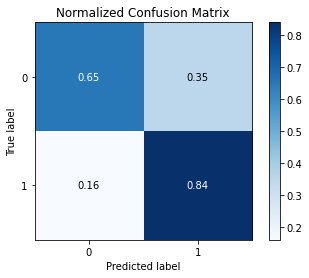

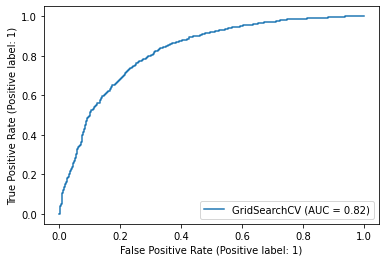

In [101]:
ad_model_eval(best_rbf_svc_b, X_test_b, y_test)

In the detailed model evaluation, Gaussian RBF SVM model trained on data in plan A has a high false positive rate.

### Visualization of Feature Importance

Since we trained Random Forest models, we can have a look of the feature importance by plotting them.

In [102]:
feature_names_a = scale_features_a + onehot_features_a
feature_names_b = scale_features_b + onehot_features_b
feature_names_c = scale_features_a + onehot_features_a + ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']

In [103]:
print(len(feature_names_a) == X_train_a.shape[1])
print(len(feature_names_b) == X_train_b.shape[1])
print(len(feature_names_c) == X_train_c.shape[1])

True
True
True


In [104]:
feature_importance_a = pd.Series(best_rf_a.best_estimator_.feature_importances_, index=feature_names_a)
feature_importance_b = pd.Series(best_rf_b.best_estimator_.feature_importances_, index=feature_names_b)
feature_importance_c = pd.Series(best_rf_c.best_estimator_.feature_importances_, index=feature_names_c)

In [105]:
def plot_importance(feature_importance, suffix):
    fig, ax = plt.subplots(figsize=(10, 8))
    feature_importance[feature_importance > 0.015].sort_values().plot.barh(ax=ax)
    ax.set_title("Feature Importances of Random Forest Model {}".format(suffix))
    ax.set_xlabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

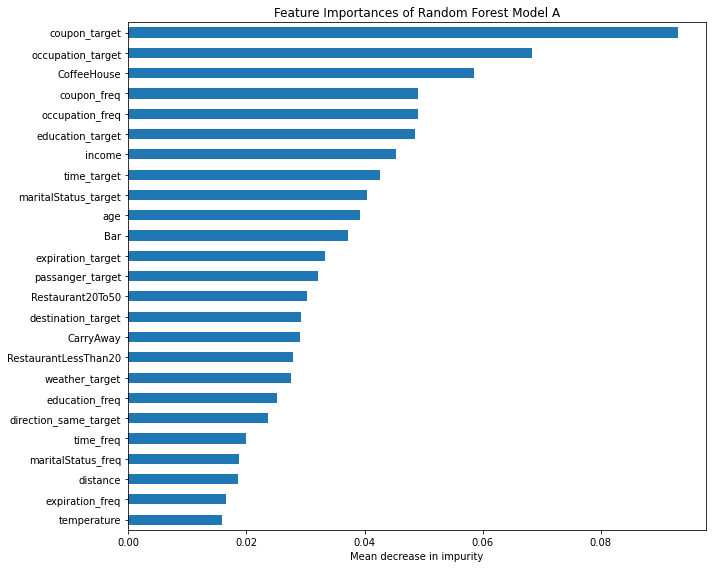

In [106]:
plot_importance(feature_importance_a, "A")

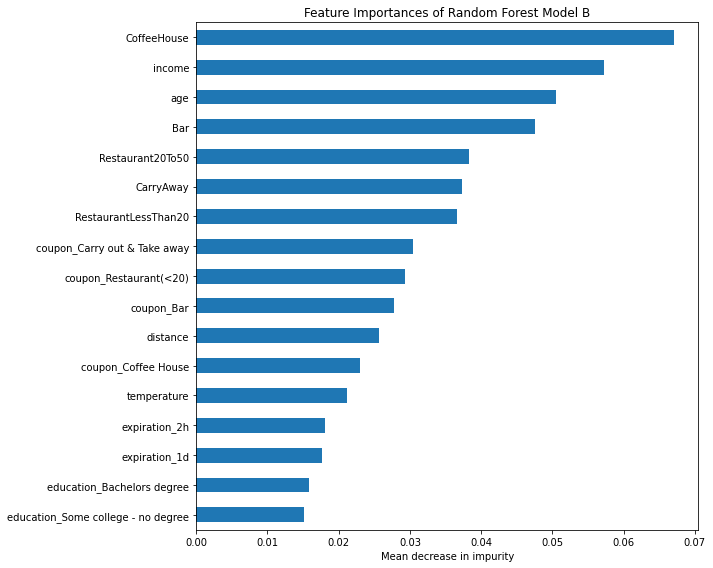

In [107]:
plot_importance(feature_importance_b, "B")

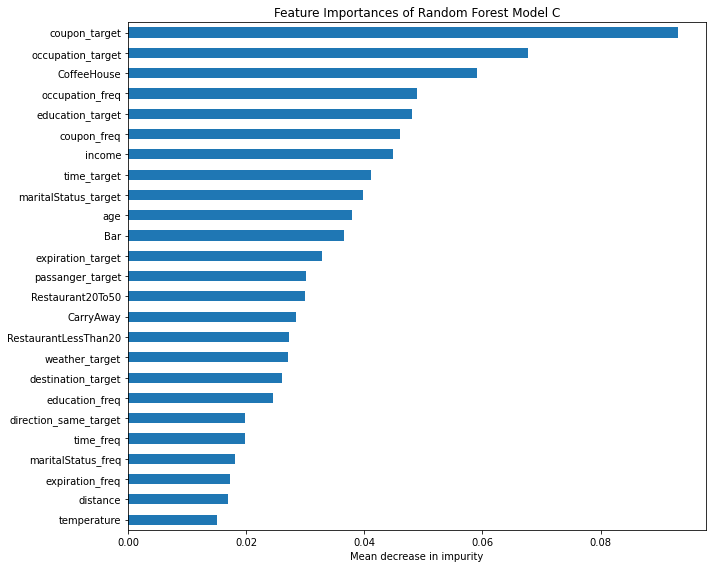

In [108]:
plot_importance(feature_importance_c, "C")

We set a threshold that only those features whose importance is higher than 0.015 can be in this plot. For data A and C, the feature importance plots are basically the same, and the cluster labels we added by kprototypes clustering does not show up in the feature importance plot which means it is not that important at least in Random Forest model. If we check the top 10 most important features, they are coupon type and occupation type's target and frequency encoding, how frequent to go to coffee houses, education and time's target encoding, income, and age.

For data B, we can see that the frequency features: CoffeeHouse, Bar, CarryAway, RestaurantLessThan20, and Restaurant20To50 are on the upper part of the plot, indicating their importances. Numerical features like income, age, temperature, and distance are quite importance as well as the Education level. Coupon features like coupon type and coupon expiration time are also in the plot. Indeed, there are some similarity between data in B and A, C. 

# Conclusion

In this notebook, we started from data cleanning and exploratory data analysis, built basic and advanced models on target and frequent encoded data, one hot encoded data, and featured expanded data to check which kind of data is best in improving model performance. Finally we reached 76.3% accuracy on test data with Gaussian RBF SVM.

The main focus of this notebook is to show various kinds of feature engineering methods applicable on categorical data and the sklearn style workflow to train multiple models at once. For categorical data encoding, we tried one hot encoding, target encoding, and frequency encoding. We also explored one of the feature expansion methods that is suitable for mixed data type: kprototypes clustering. 

In the next part, we will train GPU supported models like Neural Networks and Gradient Boosting Machines, tune the hyperparamters with Optuna, stack models to get a better predictive performance, and finally try the autoML tools.